In [1]:
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from tqdm import tqdm
from IPython.display import Audio
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense
import tensorflow as tf
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

## Dataset

In [2]:
# path = "./speech_emotion_dataset
audio_dir = "./Crema"

In [3]:
def load_and_listen(audio_path, sample_rate=22050):
    # Load the audio
    y, sr = librosa.load(audio_path, sr=sample_rate)

    # Plot the waveform
    plt.figure(figsize=(14, 4))
    librosa.display.waveshow(y, sr=sr)
    plt.title(f"Waveform of {audio_path}")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.grid(True)
    plt.show()

    # Play the audio
    return Audio(y, rate=sr)


Total audio files: 7442


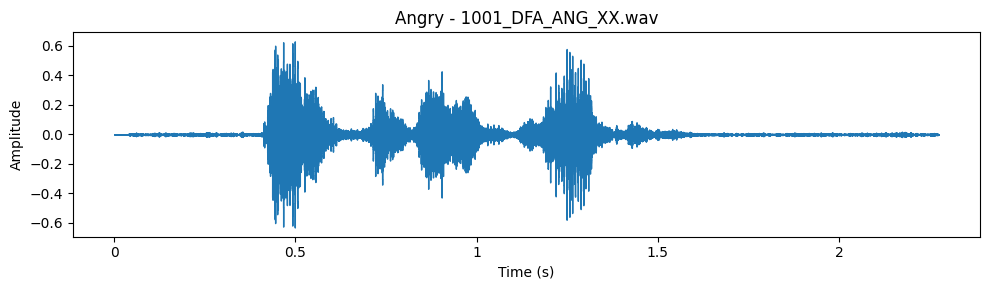

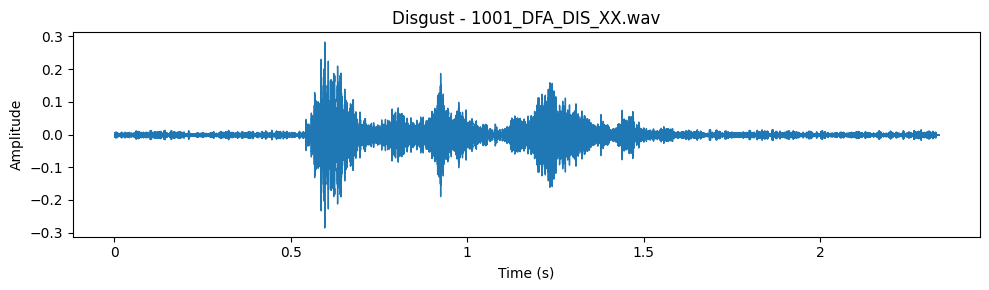

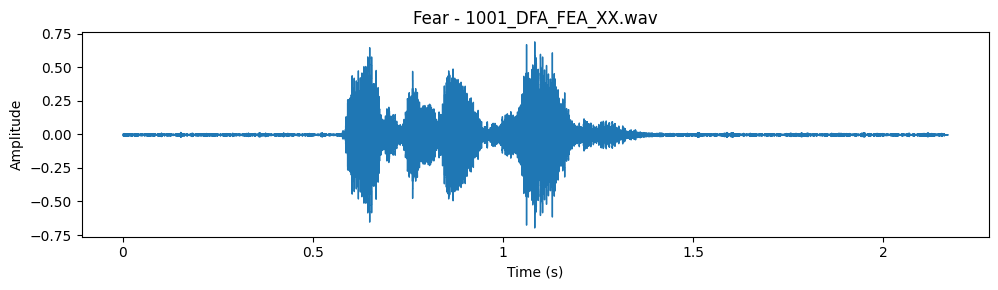

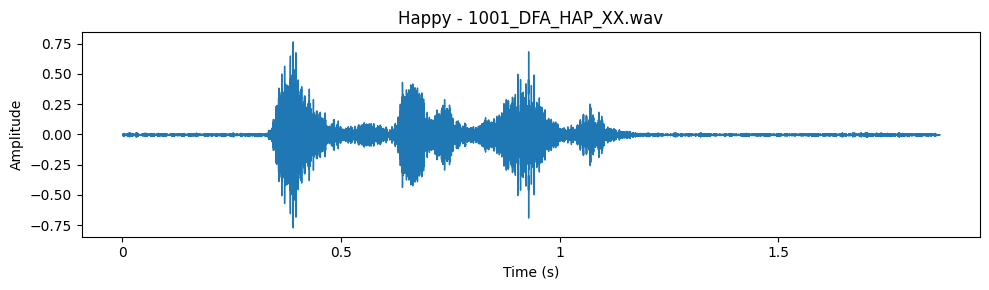

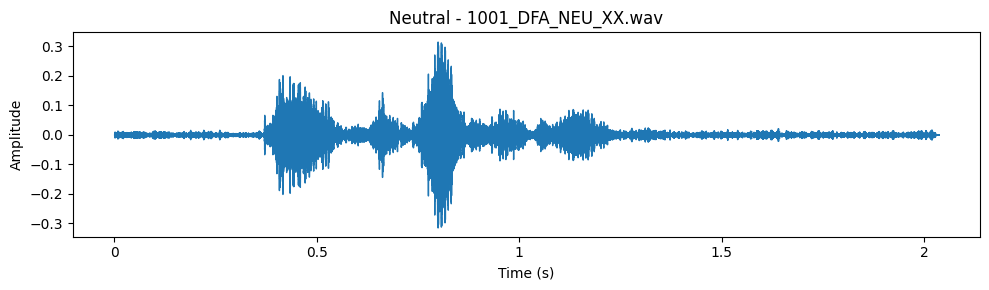

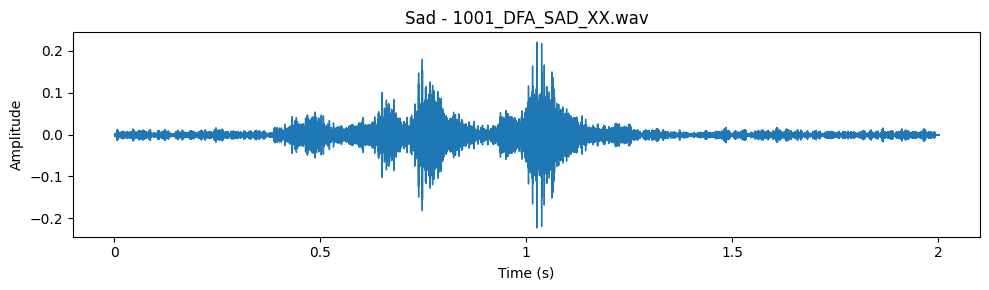

In [4]:

# Locate the folder with .wav files
# audio_dir = os.path.join(path, "Crema")  # Make sure this folder name matches what you see

# List all .wav files
audio_files = [f for f in os.listdir(audio_dir) if f.endswith(".wav")]
print(f"Total audio files: {len(audio_files)}")

# Mapping of emotion codes to labels
emotion_map = {
    "ANG": "Angry",
    "DIS": "Disgust",
    "FEA": "Fear",
    "HAP": "Happy",
    "NEU": "Neutral",
    "SAD": "Sad"
}

# Extract a sample of one file per emotion
samples = {}
for file in audio_files:
    parts = file.split('_')
    emotion_code = parts[2]
    if emotion_code in emotion_map and emotion_code not in samples:
        samples[emotion_code] = file

# Plot and listen to one file per emotion
for code, filename in samples.items():
    filepath = os.path.join(audio_dir, filename)
    signal, sr = librosa.load(filepath, sr=None)
    
    # Plot waveform
    plt.figure(figsize=(10, 3))
    librosa.display.waveshow(signal, sr=sr)
    plt.title(f"{emotion_map[code]} - {filename}")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.tight_layout()
    plt.show()
    
    # Play audio (if running in Jupyter Notebook)
    try:
        from IPython.display import Audio, display
        display(Audio(filepath))
    except:
        pass

In [5]:
def extract_features(filepath, sr=16000, frame_length=2048, hop_length=512, n_mels=128):
    # Load audio
    signal, sr = librosa.load(filepath, sr=sr)  # Use desired sampling rate
    
    # Trim silent edges
    signal, _ = librosa.effects.trim(signal)
    
    # --- Zero Crossing Rate ---
    zcr = librosa.feature.zero_crossing_rate(
        y=signal, frame_length=frame_length, hop_length=hop_length
    )[0]  # shape: (frames,)

    # --- Energy (normalized) ---
    energy = np.array([
        np.sum(signal[i:i+frame_length]**2) / frame_length
        for i in range(0, len(signal) - frame_length + 1, hop_length)
    ])
    
    # --- Mel Spectrogram ---
    mel_spec = librosa.feature.melspectrogram(
        y=signal, sr=sr, n_mels=n_mels,
        n_fft=frame_length, hop_length=hop_length
    )

    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

    return zcr, energy, mel_spec_db

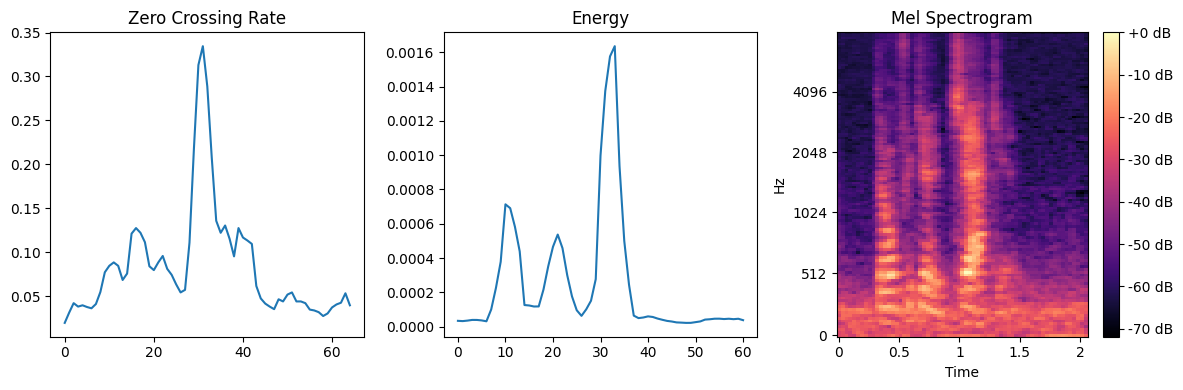

In [6]:
# Test on a sample
test_file = os.path.join(audio_dir, random.choice(audio_files))
zcr, energy, mel_spec = extract_features(test_file )
fs1 = zcr , energy
fs2 = mel_spec
# Plot features
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(zcr)
plt.title("Zero Crossing Rate")

plt.subplot(1, 3, 2)
plt.plot(energy)
plt.title("Energy")

plt.subplot(1, 3, 3)
librosa.display.specshow(mel_spec, sr=16000, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title("Mel Spectrogram")

plt.tight_layout()
plt.show()

In [7]:
# Prepare containers
zcr_list = []
energy_list = []
mel_spec_list = []
labels = []

valid_emotions = {"ANG", "DIS", "FEA", "HAP", "NEU", "SAD"}

# Loop through files
for file in tqdm(audio_files):
    parts = file.split('_')
    emotion_code = parts[2]

    if emotion_code not in valid_emotions:
        continue  # skip unknown emotions

    filepath = os.path.join(audio_dir, file)
    
    try:
        zcr, energy, mel_spec = extract_features(filepath)
        
        zcr_list.append(zcr)
        energy_list.append(energy)
        mel_spec_list.append(mel_spec)
        labels.append(emotion_code)
        
    except Exception as e:
        print(f"Failed for {file}: {e}")

100%|██████████| 7442/7442 [01:46<00:00, 70.05it/s] 


In [15]:
X =zcr_list, energy_list, mel_spec_list
print(len(zcr_list), len(energy_list), len(mel_spec_list))

le = LabelEncoder()
label_array = le.fit_transform(labels)

# Get mapping
label_map = dict(zip(le.classes_, le.transform(le.classes_)))
print("Label mapping:", label_map)
label_array.shape
print(label_array.shape)

# Convert to DataFrame
df = pd.DataFrame({
    'zcr': zcr_list,
    'energy': energy_list,
    'mel_spec': mel_spec_list,
    'label': label_array
})

X = df.drop(columns=['label'])
y = df['label']

print("Shape of features:", X.shape)
print("Shape of labels:", y.shape)


7442 7442 7442
Label mapping: {np.str_('ANG'): np.int64(0), np.str_('DIS'): np.int64(1), np.str_('FEA'): np.int64(2), np.str_('HAP'): np.int64(3), np.str_('NEU'): np.int64(4), np.str_('SAD'): np.int64(5)}
(7442,)
Shape of features: (7442, 3)
Shape of labels: (7442,)


### Splitting the data

In [9]:
# 1. Train+Val (70%) and Test (30%)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y,
    test_size=0.3,
    stratify=y,
    random_state=42
)

# 2. From Train+Val, get 5% as validation
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.05,  # 5% of 70% ≈ 3.5% of total data
    stratify=y_temp,
    random_state=42
)

# Show shapes
print("Train shape:", X_train.shape)
print("Validation shape:", X_val.shape)
print("Test shape:", X_test.shape)

Train shape: (4948, 3)
Validation shape: (261, 3)
Test shape: (2233, 3)


### Create the feature space

In [10]:
"""First feature Space""" 
X_train1 = X_train[X_train.columns[0:2]]
X_val1   = X_val[X_val.columns[0:2]]
X_test1  = X_test[X_test.columns[0:2]]

"""Second feature space"""
X_train2 = X_train[X_train.columns[2:]]
X_val2   = X_val[X_val.columns[2:]]
X_test2  = X_test[X_test.columns[2:]]

print("Train shape1:", X_train1.shape)
print("Validation shape1:", X_val1.shape)
print("Test shape1:", X_test1.shape)

print("Train shape2:", X_train2.shape)
print("Validation shape2:", X_val2.shape)
print("Test shape2:", X_test2.shape)

Train shape1: (4948, 2)
Validation shape1: (261, 2)
Test shape1: (2233, 2)
Train shape2: (4948, 1)
Validation shape2: (261, 1)
Test shape2: (2233, 1)
